<a href="https://colab.research.google.com/github/zahraDehghanian97/stock_market/blob/master/Stock.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
from keras.layers.core import Dense, Dropout
from keras.layers.recurrent import GRU
from keras.models import Sequential, load_model
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import glob


In [ ]:
! curl -L https://api.github.com/repos/zahraDehghanian97/stock_market/tarball --output repo.tar
! tar xf repo.tar --wildcards "*/tickers_data/*.csv" --strip-components=1 
! rm -rf repo.tar


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 7444k    0 7444k    0     0  3912k      0 --:--:--  0:00:01 --:--:-- 6448k


In [ ]:
def load_df_from_csv(dir_name:str) -> dict:
  stocks = {}
  for file_name in sorted(glob.glob(dir_name+'/*.csv')):
    df = pd.read_csv(file_name,names=['close'])
    dataset_name = file_name.split("/")[1].split(".csv")[0]
    print(dataset_name)
    stocks[dataset_name] = df
  return stocks

stocks = load_df_from_csv(dir_name="tickers_data")

def evaluate_performance(testing_actual, testing_predict):
    counter = 0
    for i in range(len(testing_actual)-1):
        predict=testing_predict[i+1]- testing_predict[i]
        actual = testing_actual[i+1]-testing_actual[i]
        if (actual > 0 and predict > 0) or (actual < 0 and predict < 0):
            counter+=1
    counter = round((counter / (len(testing_actual)-1))*100,2)
    return counter


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2822: DtypeWarning: Columns (2,3,4,5,6) have mixed types.Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


prices_stock_yahoo
خچرخش
شپنا


MODEL-LOADED
24/24 [==============================] - 1s 5ms/step - loss: 0.0298
Score: 0.029820004478096962
-------------------------------
evaluating performance...
Testing Accuracy:  67.7 %
Prediction for today:  -1


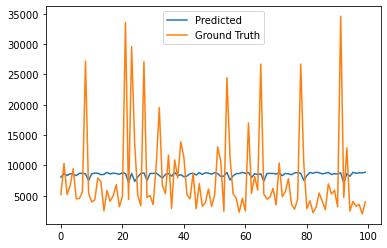

In [ ]:
# prices = pd.read_csv('tickers_data/prices_stock_prices.csv', index_col=['date'])
prices = pd.read_csv('tickers_data/شپنا.csv', index_col=['date'])

# preparing input features
prices = prices.drop(['volume'], axis=1)
prices = prices[['open', 'low', 'high', 'close']]

# preparing label data
prices_shift = prices.shift(-1)
label = prices_shift['close']

# adjusting the shape of both
prices.drop(prices.index[len(prices)-1], axis=0, inplace=True)
label.drop(label.index[len(label)-1], axis=0, inplace=True)

# conversion to numpy array
x, y = prices.values, label.values
# scaling values for model
x_scale = MinMaxScaler()
y_scale = MinMaxScaler()
X = x_scale.fit_transform(x)
Y = y_scale.fit_transform(y.reshape(-1,1))
# splitting train and test
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33)
X_train = X_train.reshape((-1,1,4))
X_test = X_test.reshape((-1,1,4))
# change today result with tomorrow to lean param tomorrow
X_train = X_train [:-1]
y_train = y_train[1:]
y_test = y_test[1:]

# build model
model_name = 'stock_price_GRU'
model = Sequential()
model.add(GRU(units=512,return_sequences=True,input_shape=(1, 4)))
model.add(Dropout(0.2))
model.add(GRU(units=256))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='mse', optimizer='adam')
model.fit(X_train,y_train,batch_size=250, epochs=50, validation_split=0.1, verbose=0)
model.save("{}.h5".format(model_name))
print('MODEL-SAVED')

# # load model
# model = load_model("{}.h5".format(model_name))
# print("MODEL-LOADED")

x_test = X_test[:-1]
score = model.evaluate(x_test, y_test)
print('Score: {}'.format(score))

yhat = model.predict(X_test)
if yhat[-1]>yhat[-2] :
   prediction_today = 1
else : 
  prediction_today = -1
yhat = yhat [:-1]
print("-------------------------------")
print('evaluating performance...')
accuracy_model = evaluate_performance(y_test, yhat)
print('Testing Accuracy: ', accuracy_model,"%")

print('Prediction for today: ', prediction_today)

yhat = y_scale.inverse_transform(yhat)
y_test = y_scale.inverse_transform(y_test)
plt.plot(yhat[-100:], label='Predicted')
plt.plot(y_test[-100:], label='Ground Truth')
plt.legend()
plt.show()